<a href="https://colab.research.google.com/github/Sella41236793/DL_Pert_11/blob/main/DL_lanjut_pert_11_SELA_41236793.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Memuat dataset...
Kamus Teks Berhasil Dibuat. Kosakata: 359
Memulai Pelatihan (1 Epoch untuk demo)...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - loss: 6.9317
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - loss: 6.9316
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - loss: 6.9318
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - loss: 6.9317
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - loss: 6.9317
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - loss: 6.9317
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step - loss: 6.9314
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 6.9316
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - loss: 6.9317
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - loss: 6.9317
Generating: a pink cute pokemon...


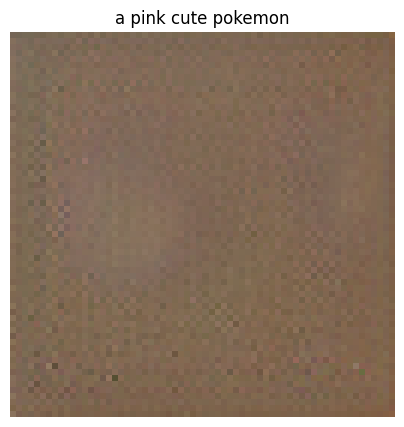

In [2]:
!pip install -q datasets diffusers transformers accelerate

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from diffusers import AutoencoderKL


print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")


max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
)

text_vectorizer.adapt([item['text'] for item in raw_dataset])
print(f"Kamus Teks Berhasil Dibuat. Kosakata: {len(text_vectorizer.get_vocabulary())}")


def preprocess_fn(item):
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0
    return item['text'], image

def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)

train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
    )
)
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

embed_dim = 256
visual_tokens_len = 255


transformer_model = keras.Sequential([
    layers.Input(shape=(seq_len + visual_tokens_len,)),
    layers.Embedding(max_tokens, embed_dim),
    layers.Dense(1024)
], name="PokemonTransformer")

class PokemonTrainer(keras.Model):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def train_step(self, data):
        text_tokens, images = data
        # Simulasi visual tokens (0-1023)
        batch_size = tf.shape(images)[0]
        visual_tokens = tf.random.uniform((batch_size, 256), minval=0, maxval=1024, dtype=tf.int32)

        vis_input = visual_tokens[:, :-1]
        vis_target = visual_tokens[:, 1:]

        with tf.GradientTape() as tape:

            combined_in = tf.concat([tf.cast(text_tokens, tf.int32), vis_input], axis=1)
            preds = self.transformer(combined_in, training=True)

            preds_vis = preds[:, seq_len:, :]
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds_vis, from_logits=True)

        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


trainer = PokemonTrainer(transformer_model)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("Memulai Pelatihan (1 Epoch untuk demo)...")
trainer.fit(train_ds.take(10), epochs=10)

def generate_pokemon(prompt):
    print(f"Generating: {prompt}...")


    vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")

    latent = torch.randn(1, 4, 8, 8) * 0.1
    with torch.no_grad():
        decoded = vae.decode(latent).sample


    image = (decoded / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).numpy()[0]

    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

generate_pokemon("a pink cute pokemon")